# Airfare ML : Predicting Flight Fares

# Introduction

In an era where travel has become not just a luxury but a necessity, the dynamics of air travel have evolved drastically. With this evolution comes the complexity of airfare pricing, a crucial factor influencing consumer decisions and airline profitability. This project, centered on developing a machine learning model to predict flight fares – Airfare ML – is born out of the need to bring more transparency and predictability to airfare pricing.

## Why This Topic?

Consumer Empowerment: In a consumer-driven market, providing accurate predictions of flight fares empowers travelers to make informed decisions. This project aims to demystify airfare pricing, enabling consumers to plan and budget their travels more effectively.

Dynamic Pricing Challenges: The airline industry is notorious for its dynamic and sometimes opaque pricing strategies. Understanding and predicting these price fluctuations are not just beneficial but essential for anyone involved in the travel industry, from individual travelers to large travel agencies.

Technological Advancement: The advent of big data and machine learning offers unprecedented opportunities to tackle complex problems like airfare prediction. This project is an exploration into harnessing these technologies to offer real-world solutions.

## Importance of Predicting this Model
Strategic Planning for Airlines: By accurately predicting flight fares, airlines can optimize their revenue management and pricing strategies. This leads to more efficient operations and potentially higher profits.

Market Competitiveness: For travel agencies and booking platforms, providing customers with the most economical options can be a significant competitive edge. This project aims to equip these entities with the tools to offer better deals.

Economic Insights: Flight fare trends can reflect broader economic patterns. Predicting these fares contributes to understanding economic factors like demand and supply dynamics, consumer spending power, and even the impact of global events.

Customization and Personalization: In the long term, this project can pave the way for more personalized travel experiences, where predictions can be tailored to individual preferences and historical data.

# Imports

In [1]:
# Basic Data Handling and Operations
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Model Evaluation and Hyperparameter Tuning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

# Miscellaneous Utilities
import warnings
warnings.filterwarnings('ignore')  # To ignore warnings that are not critical

# Setting a seed for reproducibility (optional)
np.random.seed(42)


# Load Dataset

In [2]:
# Import necessary libraries (like Pandas in Python).
# Use a function like pandas.read_csv() to load the data into a DataFrame.
# View the first few rows of the dataset with data.head() to get an initial understanding.

In [3]:
file_path = 'Scraped_dataset.csv'
df = pd.read_csv(file_path)
df.head()

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
0,15/01/2023,16/01/2023,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335"
1,15/01/2023,16/01/2023,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899"
2,15/01/2023,16/01/2023,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801"
3,15/01/2023,16/01/2023,SpiceJet \nSG-8709\nECONOMY,18:50\nDelhi,20:55\nMumbai,02h 05m,non-stop,"5,794"
4,15/01/2023,16/01/2023,Air India \nAI-805\nECONOMY,20:00\nDelhi,22:10\nMumbai,02h 10m,non-stop,"5,955"


# Preprocess Dataset (1)

In [4]:
# Splitting columns and renaming them
df[["Airline", "Flight_Code", "Class"]] = df.pop("Airline-Class").str.split('\n', expand=True)
df[["Departure", "Source"]] = df.pop("Departure Time").str.split('\n', expand=True)
df[["Arrival", "Destination"]] = df.pop("Arrival Time").str.split('\n', expand=True)

# Handling date-time conversions and feature creation in one step
df["Date of Booking"] = pd.to_datetime(df["Date of Booking"], format="%d/%m/%Y")
df["Date of Journey"] = pd.to_datetime(df["Date of Journey"], format="%d/%m/%Y")
df["Days_left"] = (df["Date of Journey"] - df["Date of Booking"]).dt.days

# e.g. 2023-03-15 becomes "Wednesday"
df["Journey_day"] = df["Date of Journey"].dt.day_name()

# Simplifying the time to part of the day transformation
time_to_part = lambda time: (
    "Early Morning" if 0 <= time < 5 else
    "Morning" if 5 <= time < 12 else
    "Afternoon" if 12 <= time < 16 else
    "Evening" if 16 <= time < 19 else
    "Night" if 19 <= time < 22 else
    "Late Night"
)

df["Dep"] = pd.to_datetime(df.pop('Departure'), format='%H:%M').dt.hour.apply(time_to_part)
df["Arr"] = pd.to_datetime(df.pop('Arrival'), format='%H:%M').dt.hour.apply(time_to_part)

# Creating 'Route' column and processing 'Price'
df["Route"] = df["Source"] + "-->" + df["Destination"]
df["Price"] = pd.to_numeric(df["Price"].str.replace(',', ''))
df["Price"] = df["Price"] * 0.012

# Handling the duration in hours
df["Duration_in_hrs"] = df["Duration"].str.replace(r'(\d+)h (\d+)m', lambda x: str(int(x.group(1)) + int(x.group(2))/60), regex=True).astype(float)

# Handling Total Stops
df["Total Stops"].value_counts()
df['Total Stops'] = df['Total Stops'].apply(lambda x: 'non-stop' if 'non-stop' in x
                                                         else '1-stop' if '1-stop' in x
                                                         else '2+-stop' if '2+-stop' in x
                                                         else x)

# Dropping unnecessary columns
df.drop(["Date of Booking", "Duration"], axis=1, inplace=True)



df.head(10)



,Date of Journey,Total Stops,Price,Airline,Flight_Code,Class,Source,Destination,Days_left,Journey_day,Dep,Arr,Route,Duration_in_hrs
0,2023-01-16,non-stop,64.020,SpiceJet,SG-8169,ECONOMY,Delhi,Mumbai,1,Monday,Night,Late Night,Delhi-->Mumbai,2.083333
1,2023-01-16,non-stop,70.788,Indigo,6E-2519,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.333333
2,2023-01-16,non-stop,69.612,GO FIRST,G8- 354,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.166667
3,2023-01-16,non-stop,69.528,SpiceJet,SG-8709,ECONOMY,Delhi,Mumbai,1,Monday,Evening,Night,Delhi-->Mumbai,2.083333
4,2023-01-16,non-stop,71.460,Air India,AI-805,ECONOMY,Delhi,Mumbai,1,Monday,Night,Late Night,Delhi-->Mumbai,2.166667
5,2023-01-16,non-stop,71.460,Air India,AI-605,ECONOMY,Delhi,Mumbai,1,Monday,Night,Late Night,Delhi-->Mumbai,2.250000
6,2023-01-16,non-stop,71.460,Air India,AI-814,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.250000
7,2023-01-16,non-stop,70.788,GO FIRST,G8- 330,ECONOMY,Delhi,Mumbai,1,Monday,Night,Late Night,Delhi-->Mumbai,2.250000
8,2023-01-16,1-stop,69.948,SpiceJet,SG-2976,ECONOMY,Delhi,Mumbai,1,Monday,Night,Morning,Delhi-->Mumbai,14.333333
9,2023-01-16,non-stop,70.788,GO FIRST,G8- 346,ECONOMY,Delhi,Mumbai,1,Monday,Night,Late Night,Delhi-->Mumbai,2.083333


# Basic info of Data

## Dataset Details
The dataset contains the following details:
- Total Rows: 452,088
- Total Columns: 13

## Column Descriptions:
1. Date_of_journey: The date on which the flight is scheduled to depart is stored in this column.
2. Journey_day: The day of the week on which the flight is scheduled to depart whichis derived from date of journey.
3. Airline: The name of the airline company is stored in the airline column.
4. Flight_code: Flight stores information regarding the plane's flight code.
5. Class: A categorical feature that contains information of flight seat class.
6. Source: City from which the flight takes off.
7. Departure: This is a derived categorical feature obtained created by grouping time periods into bins.
8. Total_stops: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
9. Arrival: This is a derived categorical feature created by grouping time intervals into bins.
10. Destination: City where the flight will land.
11. Duration_in_hours: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
12. Days_left: This is a derived characteristic that is calculated by subtracting the date of journey from the booking date.
13. Fare: This is a target variable stores the price of the flight ticket, including all taxes.

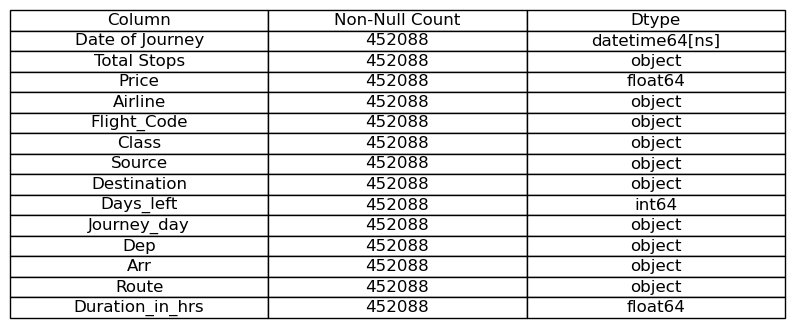

In [5]:
# Example code to create info_df from your dataset
columns = df.columns
non_null_counts = df.notnull().sum()
dtypes = df.dtypes

# Create a DataFrame with the summary info
info_df = pd.DataFrame({
    'Column': columns,
    'Non-Null Count': non_null_counts,
    'Dtype': dtypes
}).reset_index(drop=True)

# Creating a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 4))  # Adjusted the figure size

# Hide the axes
ax.axis('off')

# Creating the table with a tighter bounding box
the_table = ax.table(cellText=info_df.values, colLabels=info_df.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
the_table.scale(1.2, 1.2)

plt.show()

# Visualize the Data

## Average Prices Across Different Routes for Economy Class
Most Expensive Route: The route with the lightest color (indicating the highest average price) appears to be from Kolkata to Mumbai. This suggests that, on average, flights from Kolkata to Mumbai are the most expensive among the routes visualized.

Least Expensive Route: Conversely, the route with the darkest color (indicating the lowest average price) is from Chennai to Bangalore. This indicates that flights from Chennai to Bangalore, on average, are the least expensive among the routes displayed.

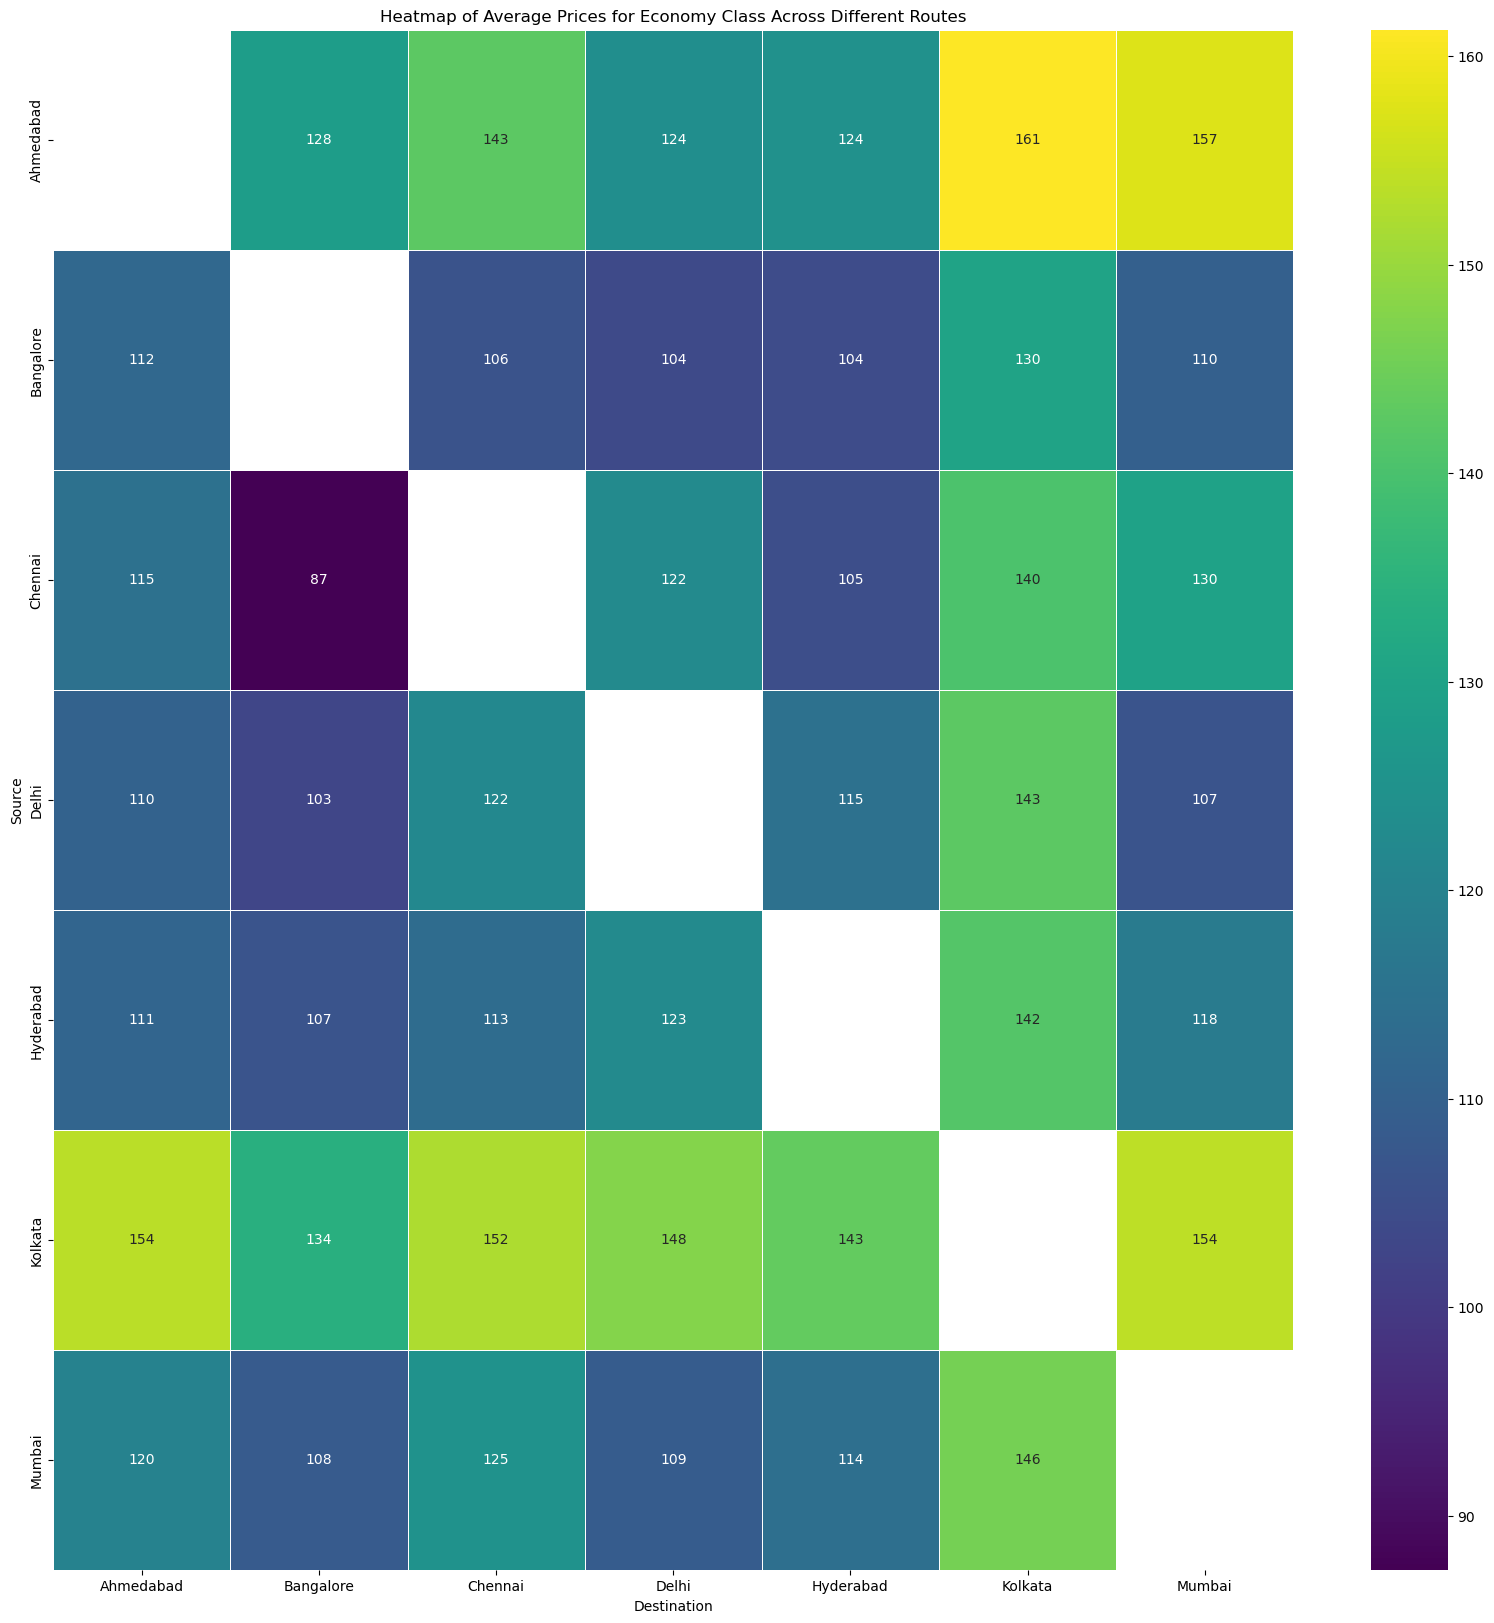

In [6]:
# To create a heatmap showing the average price across different routes for Economy class, we'll first create a pivot table.
# We'll pivot on Source and Destination to find the average price for each route.

economy_class_data = df[df['Class'] == 'ECONOMY']
# Creating the pivot table
pivot_table = economy_class_data.pivot_table(values='Price', index='Source', columns='Destination', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(pivot_table, cmap='viridis', linewidths=.5, annot=True, fmt=".0f")
plt.title('Heatmap of Average Prices for Economy Class Across Different Routes')
plt.xlabel('Destination')
plt.ylabel('Source')
plt.show()

## Average Duration Across Different Routes for Economy Class


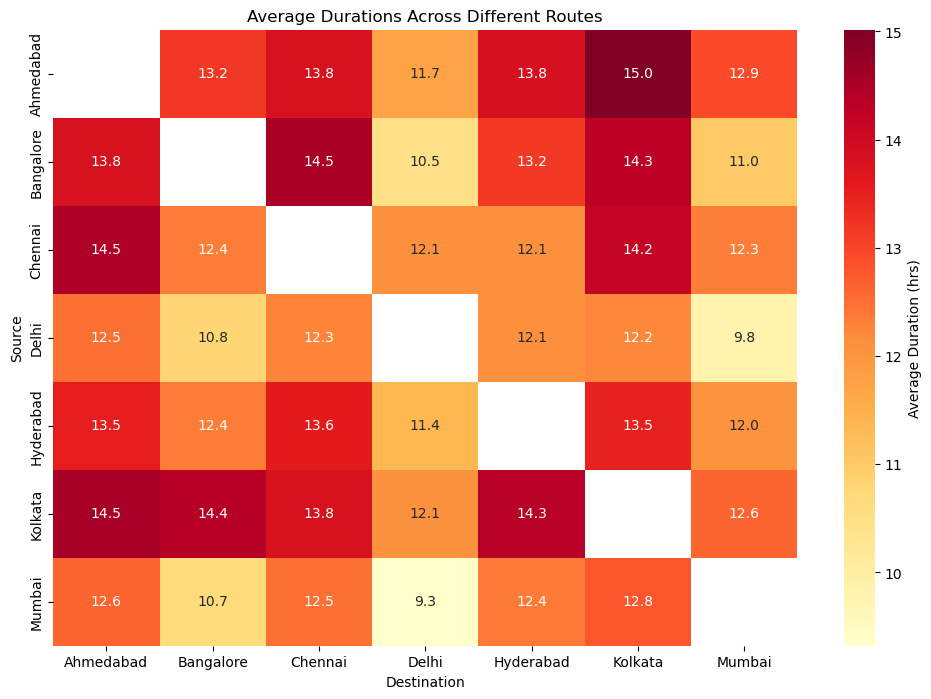


Shortest Route in Terms of Duration:
Source                 Mumbai
Destination             Delhi
Price              237.203606
Duration_in_hrs      9.322336
Name: 39, dtype: object

Longest Route in Terms of Duration:
Source              Ahmedabad
Destination           Kolkata
Price              285.127283
Duration_in_hrs     15.016181
Name: 4, dtype: object


In [7]:
# Pivot the table to create a heatmap for average durations
route_summary = df.groupby(['Source', 'Destination']).agg({
    'Price': 'mean',
    'Duration_in_hrs': 'mean'
}).reset_index()
heatmap_data_duration = route_summary.pivot_table(index='Source', columns='Destination', values='Duration_in_hrs', aggfunc='mean')

# Create a heatmap for average durations
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_duration, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Average Duration (hrs)'})
plt.title('Average Durations Across Different Routes')
plt.xlabel('Destination')
plt.ylabel('Source')
plt.show()

# Identify the shortest and longest routes in terms of duration
shortest_route = route_summary.loc[route_summary['Duration_in_hrs'].idxmin()]
longest_route = route_summary.loc[route_summary['Duration_in_hrs'].idxmax()]

print("\nShortest Route in Terms of Duration:")
print(shortest_route)
print("\nLongest Route in Terms of Duration:")
print(longest_route)


# Data Analysis

## 1. Price gap between different classes
The chart below highlights a significant price disparity between Business and Economy classes, with Business class tickets being markedly more expensive. The chart also shows a calculated ratio, emphasizing that on average, Business class tickets are several times costlier than those in Economy class. 

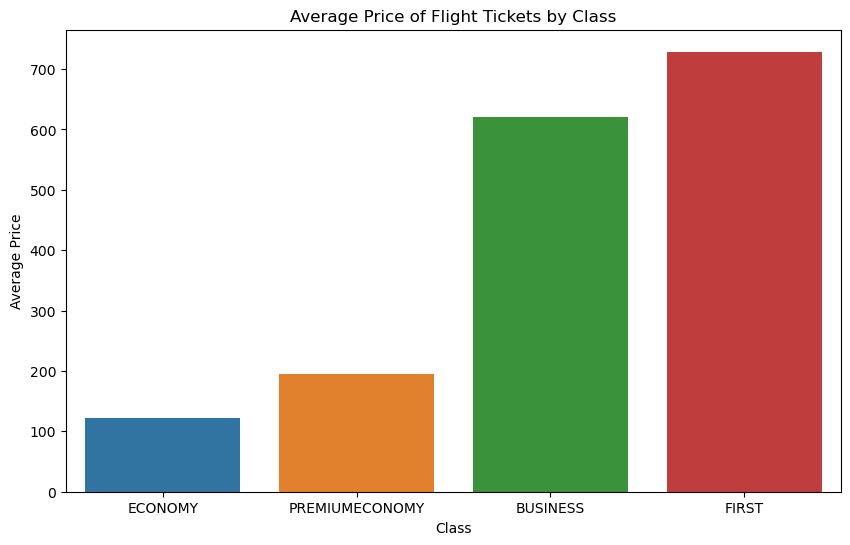

In [8]:
# Grouping by 'Class' and calculating average price
avg_price_per_class = df.groupby('Class')['Price'].mean()

# Calculating the ratio of average prices (Business to Economy)
business_price = avg_price_per_class.get('Business', None)
economy_price = avg_price_per_class.get('Economy', None)
if business_price is not None and economy_price is not None and economy_price != 0:
    price_ratio = business_price / economy_price
else:
    price_ratio = None

# Re-arranging the bar chart based on average price, with the lowest average (economy) on the leftmost
sorted_avg_price_per_class = avg_price_per_class.sort_values()

# Plotting the re-arranged bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_avg_price_per_class.index, y=sorted_avg_price_per_class.values)
plt.title(f"Average Price of Flight Tickets by Class" + 
          (f"\nBusiness is {price_ratio:.2f} times more expensive than Economy" if price_ratio else ""))
plt.xlabel('Class')
plt.ylabel('Average Price')
plt.show()

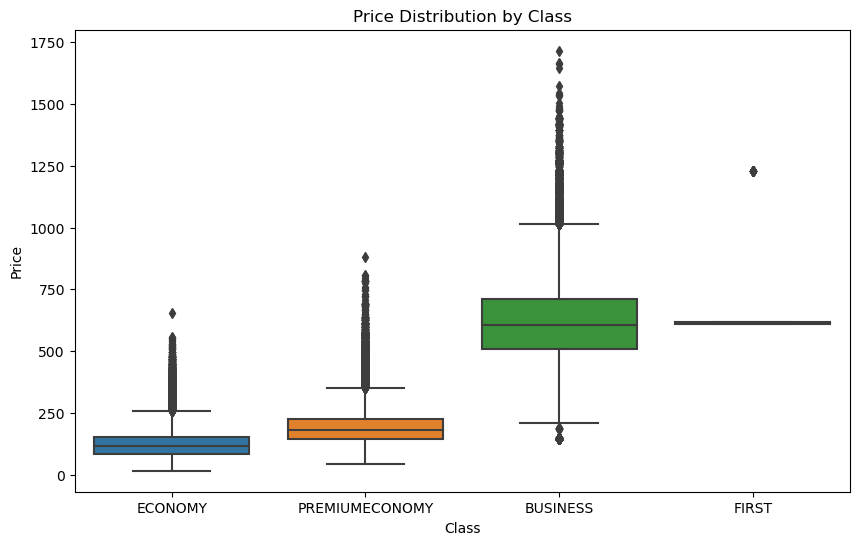

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Price', data=df)
plt.title('Price Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Price')
plt.show()

As expected, the ticket prices increase with the level of class. The Economy class has the lowest median price with fewer outliers, indicating more consistent pricing. The Business and First-class categories have a greater range of prices and outliers, reflecting the premium services and variability in what passengers might pay for enhanced comfort and amenities.

## 2. Expensive / Cheap Airlines

Vistara and AirIndia seems to be the most expensive companies and AirAsia and Akasa Air the cheapest. However for business tickets, only Vistara and AirIndia are available, and Vistara is slightly more expensive.

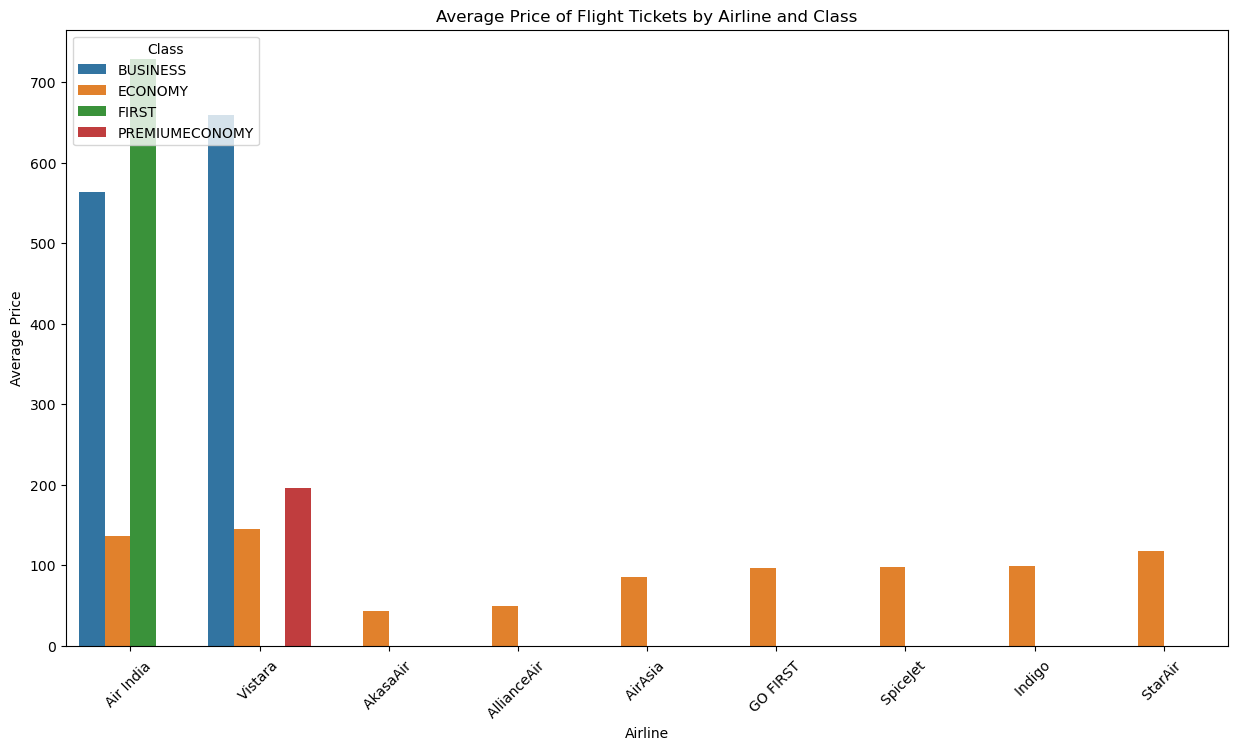

In [10]:
avg_price_per_airline_class = df.groupby(['Airline', 'Class'])['Price'].mean().reset_index()
# Sorting values for better visualization
sorted_avg_price_per_airline_class = avg_price_per_airline_class.sort_values(by=['Class', 'Price'])
# Creating a bar plot to visualize the average prices
plt.figure(figsize=(15, 8))
sns.barplot(x="Airline", y="Price", hue="Class", data=sorted_avg_price_per_airline_class)
plt.title("Average Price of Flight Tickets by Airline and Class")
plt.xlabel("Airline")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.show()

The variability in flight prices across different airlines is evident. Some airlines, such as Air India, show a broad range of prices, which could indicate a diverse offering of flight options or varying levels of service. 

## 3. Price rise drastically from 20 days before the flight
The chart illustrates a distinct pattern in flight ticket pricing relative to the days remaining before the flight.
- Initially, the prices **rise quite slowly**, indicating a period of relative price stability when the journey date is far off. 
- However, this trend **shifts dramatically** as the journey date nears. Specifically, around 20 days before the flight, there is a noticeable and steep increase in average ticket prices. This sharp escalation suggests that the cost of flight tickets tends to increase significantly as the departure date approaches, emphasizing the potential cost benefits of booking flights well in advance. The chart clearly underscores a critical insight into airline pricing strategies: prices remain relatively steady until a certain point close to the flight date, after which they rise drastically, signaling a last-minute premium for travelers.

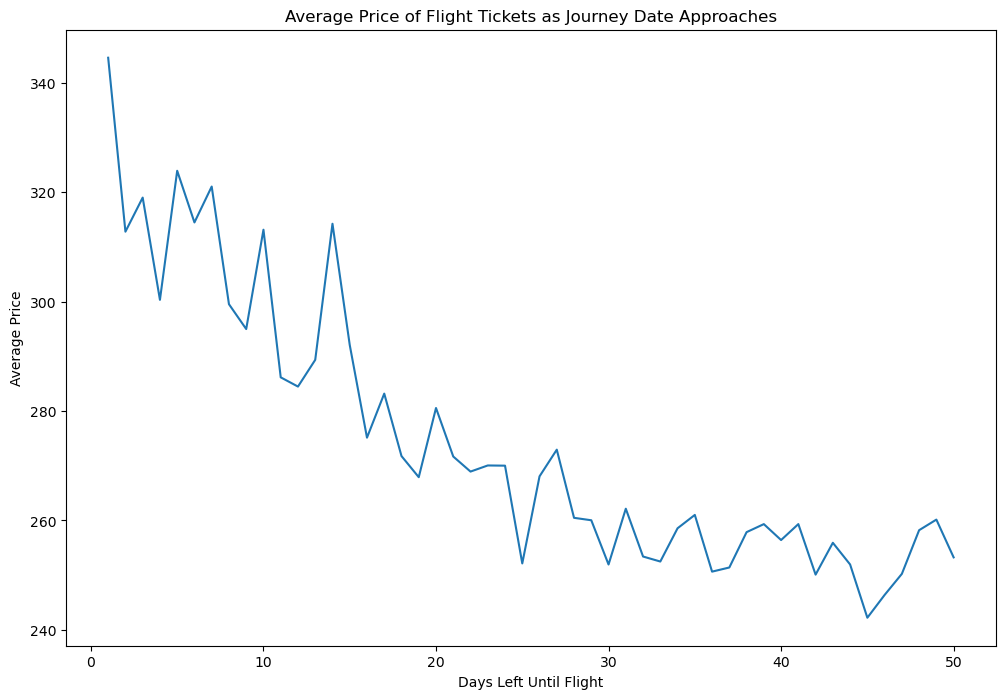

In [11]:
avg_price_per_days_left = df.groupby('Days_left')['Price'].mean().reset_index()
sorted_avg_price_per_days_left = avg_price_per_days_left.sort_values(by='Days_left')
plt.figure(figsize=(12, 8))
sns.lineplot(x='Days_left', y='Price', data=sorted_avg_price_per_days_left)
plt.title("Average Price of Flight Tickets as Journey Date Approaches")
plt.xlabel('Days Left Until Flight')
plt.ylabel('Average Price')
plt.show()

## 4. Price vs. Duration
### Economy
1. Trend for Economy Class: the prices of Economy class tickets also tend to rise with increasing flight duration. This is evident for flights of **shorter to moderate durations**.
2. Stabilization Beyond Peak: After reaching the peak, the average prices for longer flights in Economy class **either stabilize or show a slight decrease**, indicating a ceiling in pricing for long-duration flights within the Economy class.


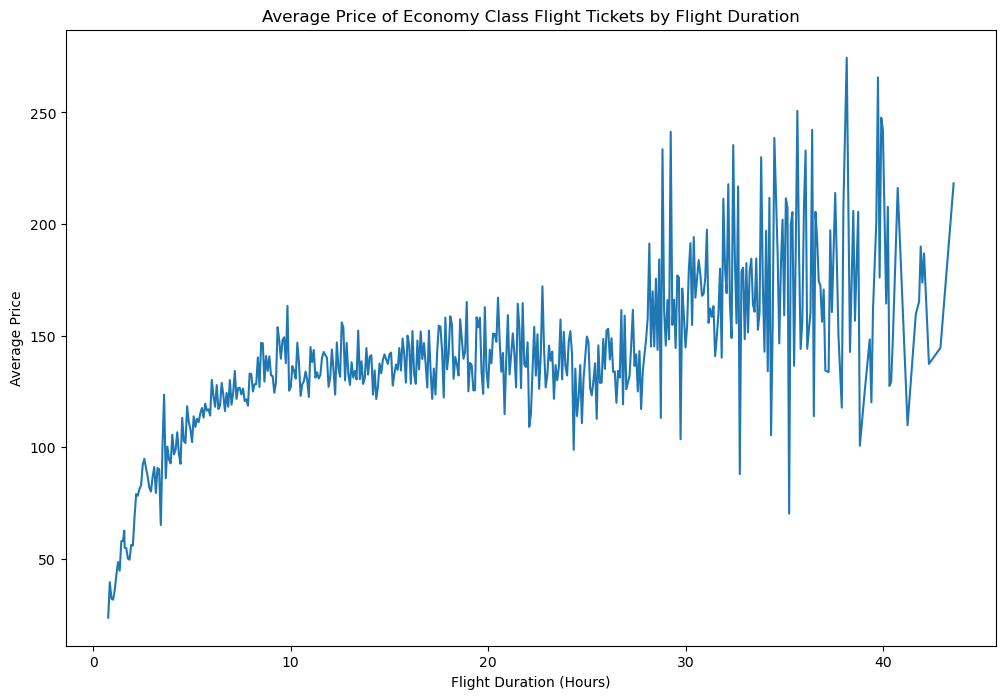

In [12]:
# Filtering the dataset to include only Economy class for the analysis
economy_data = df[df['Class'] == 'ECONOMY']

# Creating the 'Duration_in_hrs' column if it doesn't exist
if 'Duration_in_hrs' not in economy_data:
    economy_data["Duration_in_hrs"] = economy_data["Duration"].str.extract(r'(\d+)h').astype(float) + economy_data["Duration"].str.extract(r'(\d+)m').astype(float)/60

# Grouping by 'Duration_in_hrs' and calculating the average price for Economy class
avg_price_per_duration_economy = economy_data.groupby('Duration_in_hrs')['Price'].mean().reset_index()

# Sorting the DataFrame based on 'Duration_in_hrs'
sorted_avg_price_per_duration_economy = avg_price_per_duration_economy.sort_values(by='Duration_in_hrs')

# Plotting the line chart for Economy class
plt.figure(figsize=(12, 8))
sns.lineplot(x='Duration_in_hrs', y='Price', data=sorted_avg_price_per_duration_economy)
plt.title("Average Price of Economy Class Flight Tickets by Flight Duration")
plt.xlabel('Flight Duration (Hours)')
plt.ylabel('Average Price')
plt.show()

### Business class
1. The trend for Business class tickets shows that the prices generally rise with increasing flight duration. This pattern is noticeable for flights of varying durations.
2. Similar to the Economy class, there is a point where the average prices for Business class flights peak. Beyond this point, the prices either stabilize or slightly decrease, indicating a maximum price level for longer flights in Business class.
3. The chart offers insights into the pricing dynamics of Business class flights, highlighting that while longer flights tend to be more expensive, there is a plateau in the price increase for very long-duration flights.

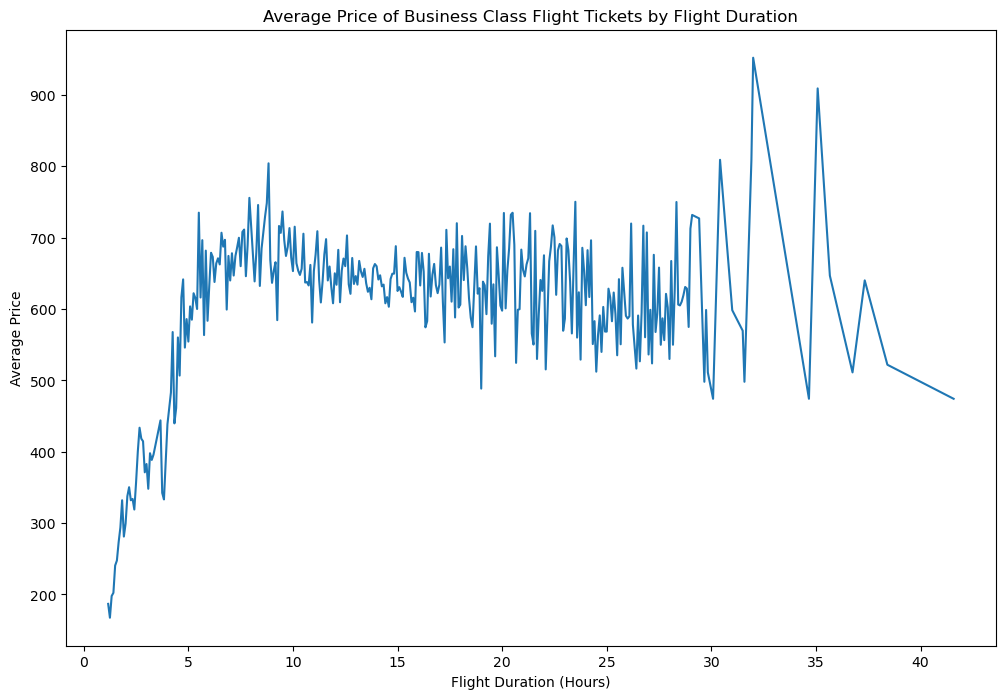

In [13]:
business_data = df[df['Class'] == 'BUSINESS']
if 'Duration_in_hrs' not in business_data:
    business_data["Duration_in_hrs"] = business_data["Duration"].str.extract(r'(\d+)h').astype(float) + business_data["Duration"].str.extract(r'(\d+)m').astype(float)/60
avg_price_per_duration_business = business_data.groupby('Duration_in_hrs')['Price'].mean().reset_index()
sorted_avg_price_per_duration_business = avg_price_per_duration_business.sort_values(by='Duration_in_hrs')
# Plotting the line chart for Business class
plt.figure(figsize=(12, 8))
sns.lineplot(x='Duration_in_hrs', y='Price', data=sorted_avg_price_per_duration_business)
plt.title("Average Price of Business Class Flight Tickets by Flight Duration")
plt.xlabel('Flight Duration (Hours)')
plt.ylabel('Average Price')
plt.show()

### Economy vs Business
Price Difference Between Classes: There is a clear and consistent price difference between Economy and Business classes across all flight durations. Business class tickets are consistently more expensive than Economy class tickets.

Trend Similarities and Differences: Both classes show a trend where prices increase with flight duration. However, the rate of increase and the peak points may differ. While both classes show a plateau or decrease in prices after a certain flight duration, the peak points and the extent of price changes are distinct.

Economic and Business Class Dynamics: The chart highlights that the pricing dynamics of the two classes, though similar in pattern, are different in scale. The Business class maintains a higher price level throughout, reflecting the premium nature of the service.

Insight into Pricing Strategies: This comparison offers insights into the airlines' pricing strategies for different classes, showing how they differentiate between Economy and Business class offerings not just in service but also in pricing, particularly as flight duration changes.

Overall, this visualization provides a comprehensive view of how flight duration impacts ticket pricing in both Economy and Business classes, underlining the premium pricing strategy for Business class regardless of the duration of the flight.

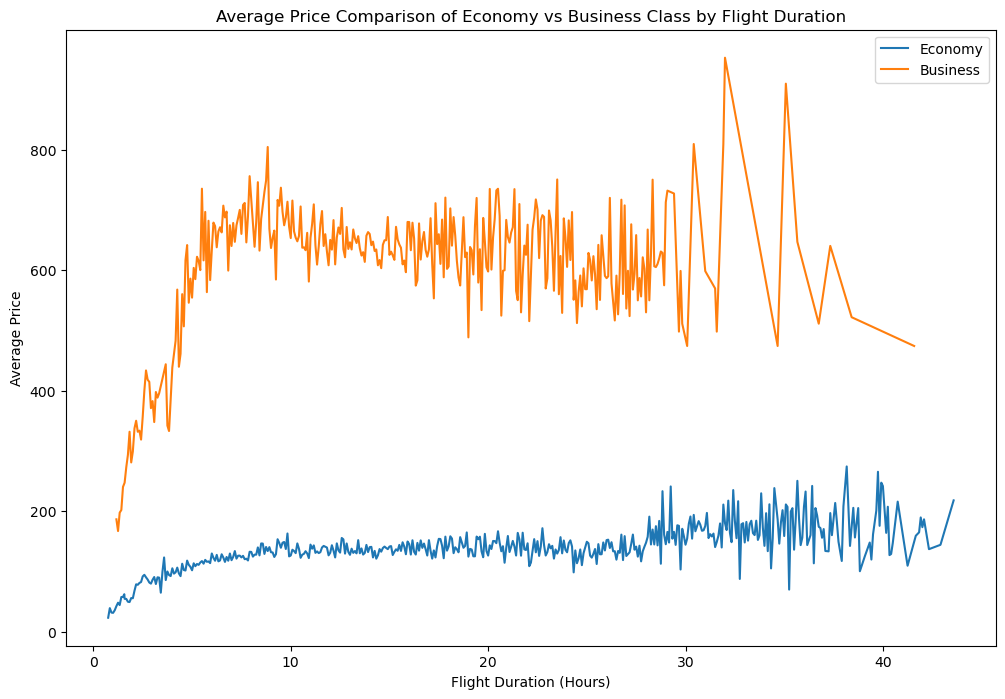

In [14]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='Duration_in_hrs', y='Price', data=sorted_avg_price_per_duration_economy, label='Economy')
# Business class plot
sns.lineplot(x='Duration_in_hrs', y='Price', data=sorted_avg_price_per_duration_business, label='Business')
plt.title("Average Price Comparison of Economy vs Business Class by Flight Duration")
plt.xlabel('Flight Duration (Hours)')
plt.ylabel('Average Price')
plt.legend()
plt.show()

## 5. Time of the flight vs Price

For the time of the flight:
For economy class, same route, early mormimg arrivals are more cheaper and evening arrivals are expensive. It seems that late night departures are cheaper and morning departures are expensive.

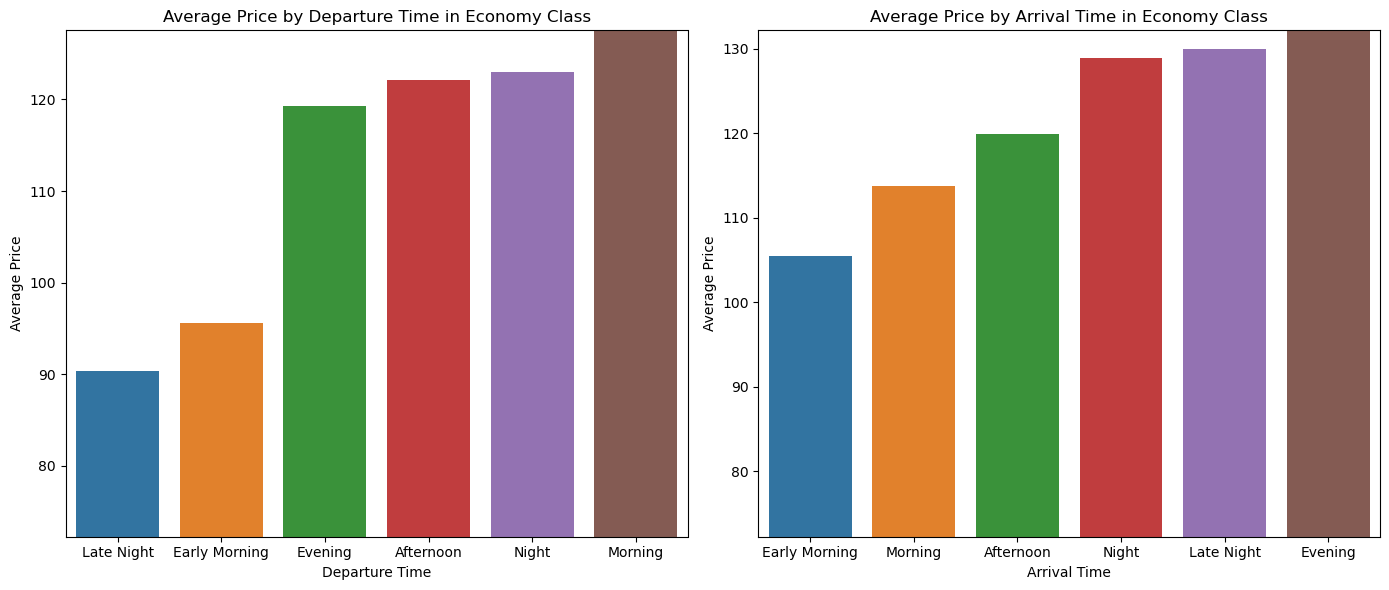

In [15]:
# Group by 'Dep' (Departure Time) and calculate the average price
avg_price_by_departure_economy = economy_class_data.groupby('Dep')['Price'].mean().reset_index()

# Sort the DataFrame based on the average price
sorted_avg_price_by_departure_economy = avg_price_by_departure_economy.sort_values(by='Price')

# Group by 'Arr' (Arrival Time) and calculate the average price
avg_price_by_arrival_economy = economy_class_data.groupby('Arr')['Price'].mean().reset_index()

# Sort the DataFrame based on the average price
sorted_avg_price_by_arrival_economy = avg_price_by_arrival_economy.sort_values(by='Price')

y_axis_min_value = sorted_avg_price_by_departure_economy['Price'].min() * 0.8

plt.figure(figsize=(14, 6))

# Plot for Departure Time in Economy Class
plt.subplot(1, 2, 1)
sns.barplot(x='Dep', y='Price', data=sorted_avg_price_by_departure_economy)
plt.ylim(y_axis_min_value, sorted_avg_price_by_departure_economy['Price'].max())
plt.title("Average Price by Departure Time in Economy Class")
plt.xlabel('Departure Time')
plt.ylabel('Average Price')

# Plot for Arrival Time in Economy Class
plt.subplot(1, 2, 2)
sns.barplot(x='Arr', y='Price', data=sorted_avg_price_by_arrival_economy)
plt.ylim(y_axis_min_value, sorted_avg_price_by_arrival_economy['Price'].max())
plt.title("Average Price by Arrival Time in Economy Class")
plt.xlabel('Arrival Time')
plt.ylabel('Average Price')

plt.tight_layout()
plt.show()

###### Time of the Flight Vs Price with weekday/weekend comparison

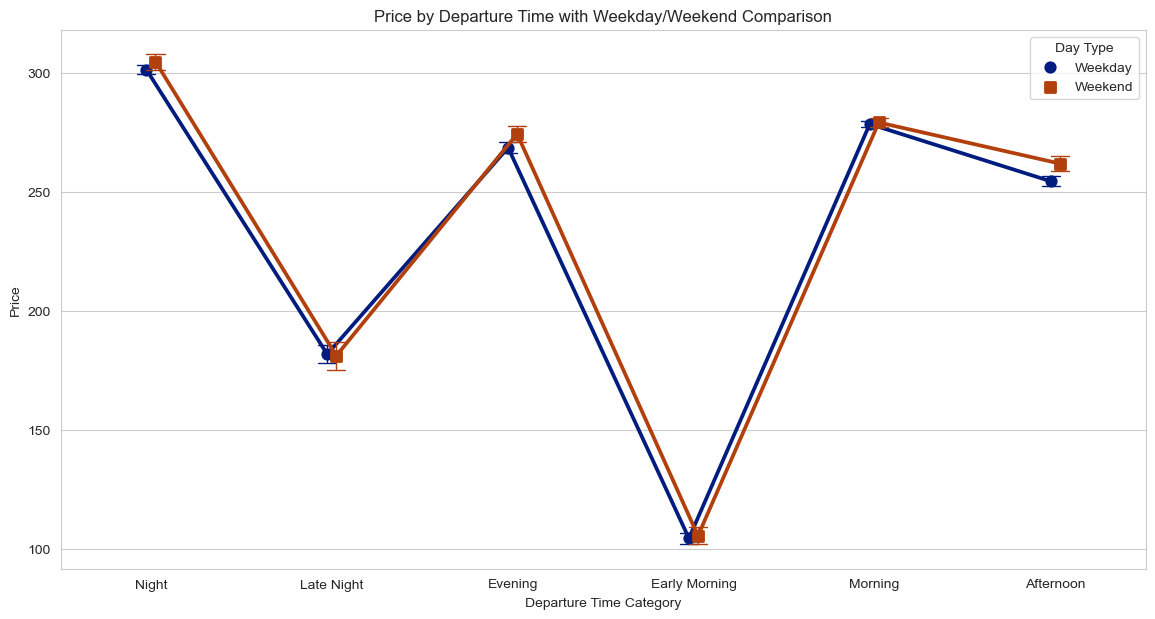

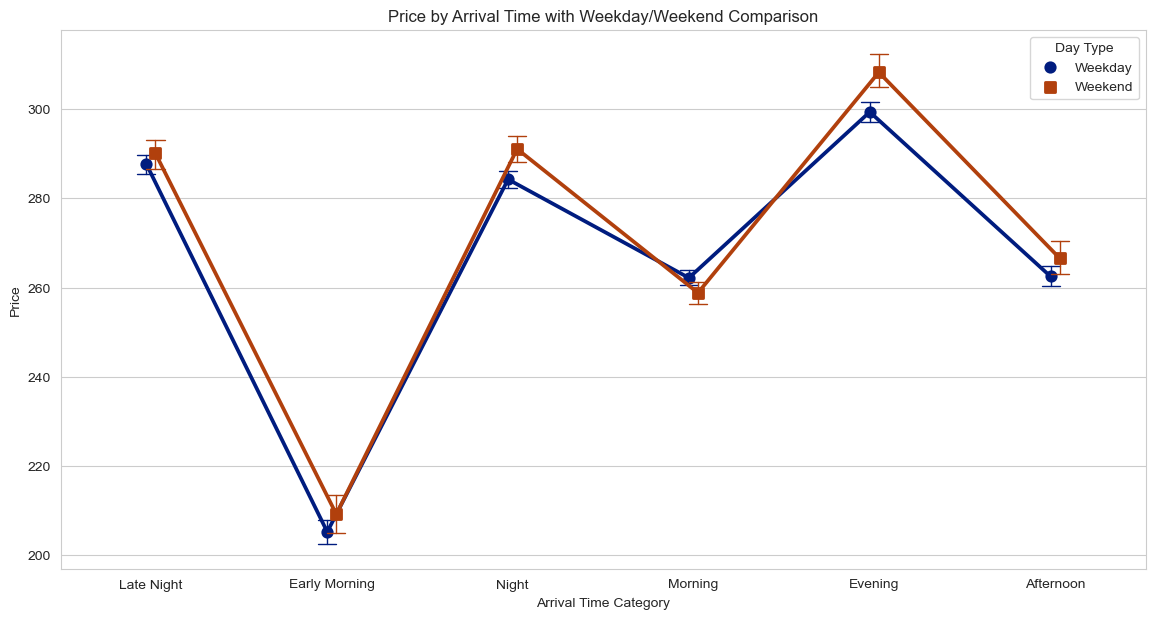

In [16]:

# Visualize the relationship with a point plot
df['Day_Type'] = df['Journey_day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Now let's create interaction point plots for 'Dep', 'Arr', and 'Day_Type' against 'Price'.

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a point plot for 'Dep' vs 'Price' with hue 'Day_Type'
plt.figure(figsize=(14, 7))
sns.pointplot(data=df, x='Dep', y='Price', hue='Day_Type', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, palette='dark')
plt.title('Price by Departure Time with Weekday/Weekend Comparison')
plt.xlabel('Departure Time Category')
plt.ylabel('Price')
plt.legend(title='Day Type')
plt.show()

# Create a point plot for 'Arr' vs 'Price' with hue 'Day_Type'
plt.figure(figsize=(14, 7))
sns.pointplot(data=df, x='Arr', y='Price', hue='Day_Type', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, palette='dark')
plt.title('Price by Arrival Time with Weekday/Weekend Comparison')
plt.xlabel('Arrival Time Category')
plt.ylabel('Price')
plt.legend(title='Day Type')
plt.show()

1.The similarity in the weekday and weekend lines also suggests that the day of the week may not be a major differentiator in pricing for departure times/arrival time. 

## 6. Journey_day vs Price

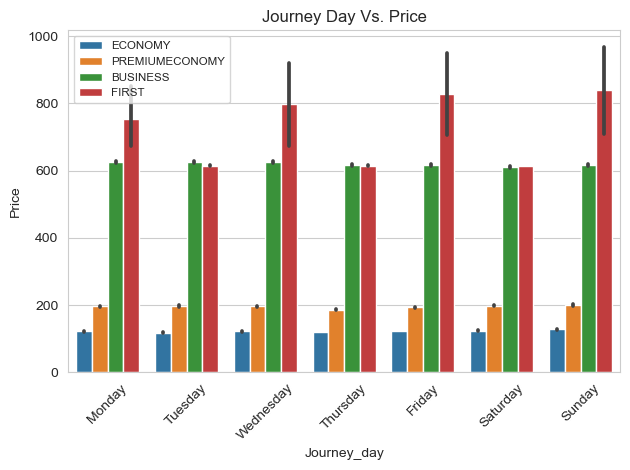

In [17]:
sns.barplot(data=df, x="Journey_day", y="Price", hue="Class", 
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Journey Day Vs. Price")
plt.legend(fontsize='small')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()

##### average price across different days of the week for each flight class, indicating that 'Journey_day' has a minimal impact on pricing. 

## 7. Number of stops vs Price
In general, the more stops there are, the more expensive the flight ticket is.

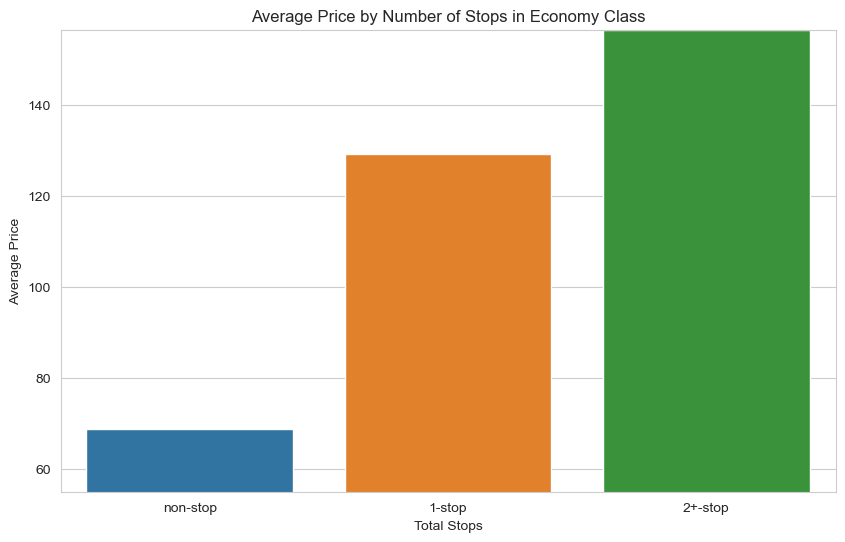

In [18]:
# Grouping by 'Total Stops' and calculating the average price for Economy class
avg_price_by_stops_economy = economy_class_data.groupby('Total Stops')['Price'].mean().reset_index()

# Group by 'Arr' (Arrival Time) and calculate the average price
avg_price_by_arrival_economy = economy_class_data.groupby('Arr')['Price'].mean().reset_index()

# Sort the DataFrame based on the average price
sorted_avg_price_by_arrival_economy = avg_price_by_arrival_economy.sort_values(by='Price')

# Sorting the DataFrame based on 'Total Stops'
sorted_avg_price_by_stops_economy = avg_price_by_stops_economy.sort_values(by='Price')

# Adjusting the y-axis to focus on price differences
y_axis_min_stops = sorted_avg_price_by_stops_economy['Price'].min() * 0.8

# Plotting the chart for Economy class based on the number of stops
plt.figure(figsize=(10, 6))
sns.barplot(x='Total Stops', y='Price', data=sorted_avg_price_by_stops_economy)
plt.ylim(y_axis_min_stops, sorted_avg_price_by_stops_economy['Price'].max())
plt.title("Average Price by Number of Stops in Economy Class")
plt.xlabel('Total Stops')
plt.ylabel('Average Price')
plt.show()


# Data Preprocessing (2)

### Check for Missing Values

In [19]:
# Use data.isnull().sum() to identify columns with missing values.
# Decide on strategies for handling missing data (imputation, removal, etc.).

In [20]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({'Count': missing_values, 'Percentage': missing_percentage})
print("Missing Values in Each Column:")
print(missing_info)

Missing Values in Each Column:
                 Count  Percentage
Date of Journey      0         0.0
Total Stops          0         0.0
Price                0         0.0
Airline              0         0.0
Flight_Code          0         0.0
Class                0         0.0
Source               0         0.0
Destination          0         0.0
Days_left            0         0.0
Journey_day          0         0.0
Dep                  0         0.0
Arr                  0         0.0
Route                0         0.0
Duration_in_hrs      0         0.0
Day_Type             0         0.0


Since the percentage for all values are 0, it means that there's no missing values.

### Check for Duplicates

In [21]:
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 6722


This indicates that there are 6722 duplicate rows. These rows are not neccessary for further evaluation, so we need to remove them.

In [22]:
df = df.drop_duplicates()
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


Now the number of duplicate rows are 0, we can proceed with further investigation.

### Identify Outliers

In [23]:
import math
cities = {
    "Delhi": (28.7041, 77.1025),
    "Mumbai": (19.0760, 72.8777),
    "Bangalore": (12.9716, 77.5946),
    "Hyderabad": (17.3850, 78.4867),
    "Kolkata": (22.5726, 88.3639),
    "Chennai": (13.0827, 80.2707),
    "Ahmedabad": (23.0225, 72.5714)
}

# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

# Function to calculate distance between two cities in a DataFrame row
def calculate_distance(row):
    city1, city2 = row['Source'], row['Destination']
    lat1, lon1 = cities[city1]
    lat2, lon2 = cities[city2]
    return haversine(lat1, lon1, lat2, lon2)

# Apply the function to each row
df['Distance(km)'] = df.apply(calculate_distance, axis=1)

df


,Date of Journey,Total Stops,Price,Airline,Flight_Code,Class,Source,Destination,Days_left,Journey_day,Dep,Arr,Route,Duration_in_hrs,Day_Type,Distance(km)
0,2023-01-16,non-stop,64.020,SpiceJet,SG-8169,ECONOMY,Delhi,Mumbai,1,Monday,Night,Late Night,Delhi-->Mumbai,2.083333,Weekday,1153.241291
1,2023-01-16,non-stop,70.788,Indigo,6E-2519,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.333333,Weekday,1153.241291
2,2023-01-16,non-stop,69.612,GO FIRST,G8- 354,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.166667,Weekday,1153.241291
3,2023-01-16,non-stop,69.528,SpiceJet,SG-8709,ECONOMY,Delhi,Mumbai,1,Monday,Evening,Night,Delhi-->Mumbai,2.083333,Weekday,1153.241291
4,2023-01-16,non-stop,71.460,Air India,AI-805,ECONOMY,Delhi,Mumbai,1,Monday,Night,Late Night,Delhi-->Mumbai,2.166667,Weekday,1153.241291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452081,2023-03-06,1-stop,735.624,Vistara,UK-918,BUSINESS,Ahmedabad,Chennai,50,Monday,Morning,Evening,Ahmedabad-->Chennai,11.250000,Weekday,1371.808916
452082,2023-03-06,1-stop,780.336,Vistara,UK-946,BUSINESS,Ahmedabad,Chennai,50,Monday,Morning,Night,Ahmedabad-->Chennai,11.166667,Weekday,1371.808916
452083,2023-03-06,1-stop,780.336,Vistara,UK-926,BUSINESS,Ahmedabad,Chennai,50,Monday,Morning,Night,Ahmedabad-->Chennai,13.083333,Weekday,1371.808916
452084,2023-03-06,1-stop,831.048,Vistara,UK-918,BUSINESS,Ahmedabad,Chennai,50,Monday,Morning,Evening,Ahmedabad-->Chennai,11.250000,Weekday,1371.808916


### todo: fix it and put it into data analysis part

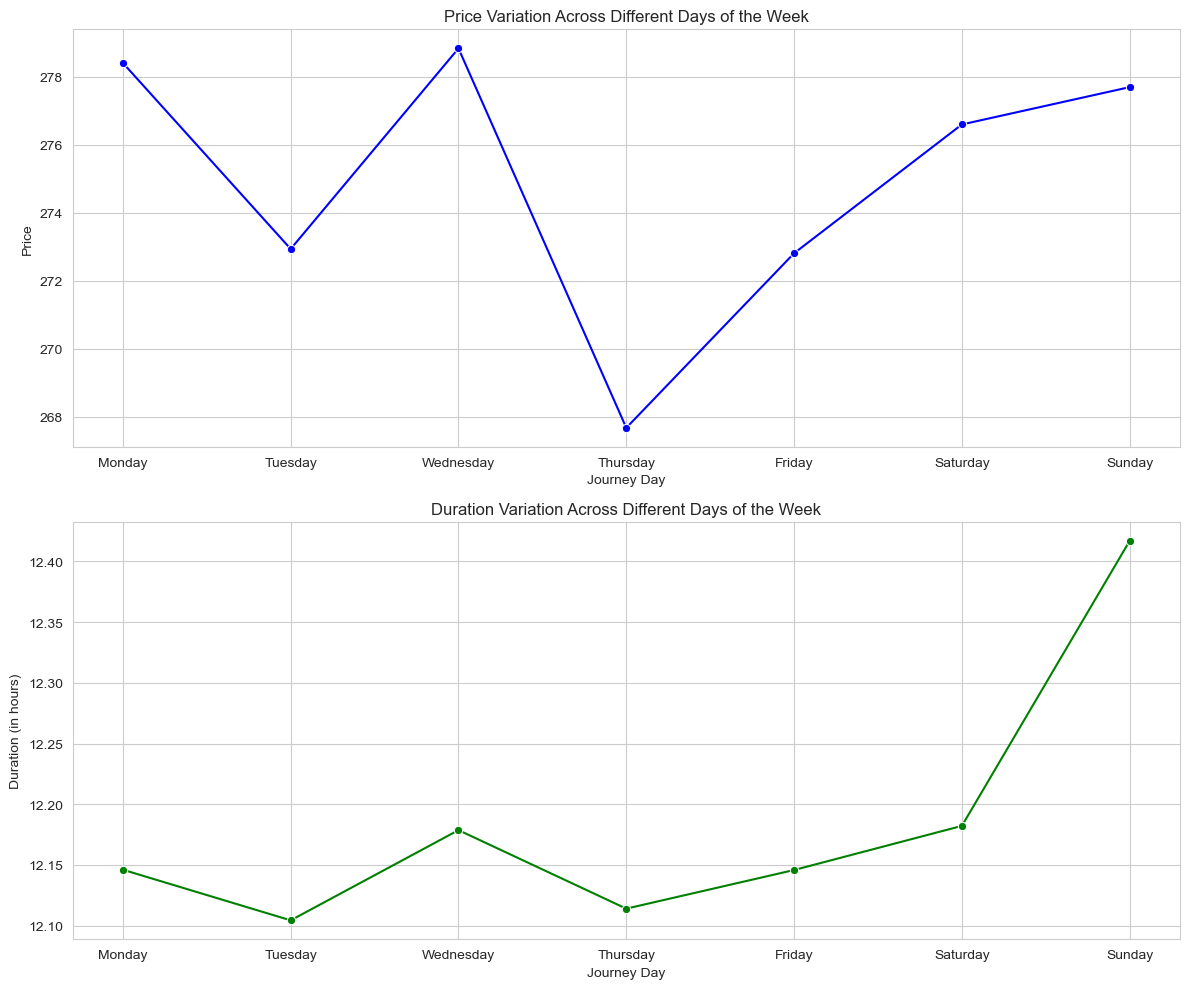

In [24]:
# Create subplots for Price and Duration
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Plot Price vs Journey_day
sns.lineplot(data=df, x='Journey_day', y='Price', ax=axes[0], ci=None, marker='o', color='blue')
axes[0].set_title('Price Variation Across Different Days of the Week')
axes[0].set_xlabel('Journey Day')
axes[0].set_ylabel('Price')
axes[0].grid(True)

# Plot Duration_in_hrs vs Journey_day
sns.lineplot(data=df, x='Journey_day', y='Duration_in_hrs', ax=axes[1], ci=None, marker='o', color='green')
axes[1].set_title('Duration Variation Across Different Days of the Week')
axes[1].set_xlabel('Journey Day')
axes[1].set_ylabel('Duration (in hours)')
axes[1].grid(True)

# Adjust subplot spacing
plt.tight_layout()

# Show the plots
plt.show()

In [25]:
# We need to create a new copy of df
df_temp = df.copy()
df_temp = df_temp.drop('Flight_Code', axis=1)

## Encode

In [26]:
# Encode the ordinal variables Total Stops, Class, Journey_day, Dep, Arr
df_enc = df_temp.copy()
df_enc['Total Stops'] = df_enc['Total Stops'].replace({'non-stop': 0, '1-stop': 1, '2+-stop': 2}).astype(int)
df_enc['Class'] = df_enc['Class'].replace({'ECONOMY': 0, 'PREMIUMECONOMY': 1, 'BUSINESS': 2, 'FIRST': 3}).astype(int)
df_enc['Journey_day'] = df_enc["Journey_day"].map({'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6})
df_enc['Dep'] = df_enc['Dep'].map({'Early Morning': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4, 'Late Night': 5})
df_enc['Arr'] = df_enc['Arr'].map({'Early Morning': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4, 'Late Night': 5})
df_enc['Day_Type'] = df_enc['Day_Type'].map({'Weekday': 0, 'Weekend': 1})

# Create dummy variables for Airline, Source, Destination with 0/1 encoding
#cols = ['Airline', 'Source', 'Destination']
#dummies = pd.get_dummies(df_enc[cols], drop_first=True, dtype='uint8')
#df_enc = pd.concat([df_enc, dummies], axis=1)

df_enc.drop(['Date of Journey', 'Airline', 'Source', 'Destination', 'Route'], axis=1, inplace=True)

#df_enc.columns

In [27]:
df_enc.head(100)

,Total Stops,Price,Class,Days_left,Journey_day,Dep,Arr,Duration_in_hrs,Day_Type,Distance(km)
0,0,64.020,0,1,0,4,5,2.083333,0,1153.241291
1,0,70.788,0,1,0,5,0,2.333333,0,1153.241291
2,0,69.612,0,1,0,5,0,2.166667,0,1153.241291
3,0,69.528,0,1,0,3,4,2.083333,0,1153.241291
4,0,71.460,0,1,0,4,5,2.166667,0,1153.241291
...,...,...,...,...,...,...,...,...,...,...
95,1,148.320,0,1,0,1,3,10.916667,0,1153.241291
96,1,134.460,0,1,0,3,0,7.250000,0,1153.241291
97,1,147.432,0,1,0,3,3,24.500000,0,1153.241291
98,0,140.760,0,1,0,2,3,2.083333,0,1153.241291


# todo:
 split the data into two parts, one with only economy class and one with only business class, we are going to have different models for the two

## Splitting Data

In [28]:
X = df_enc.drop('Price', axis=1)  # features
y = df_enc['Price']  # target variable

# # Split the data into training and test sets
# # This example uses 80% of the data for training and 20% for testing, which is a common split.
# # The random_state parameter ensures that the splits are reproducible.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# df_enc.head()

# Initial split into training and temporary test set (e.g., 80% training, 20% temporary test)
X_train_temp, X_temp_test, y_train_temp, y_temp_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary test set into actual test and validation set (e.g., 50% test, 50% validation of the temporary test set)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp_test, y_temp_test, test_size=0.5, random_state=42)


## Linear Regression

In [29]:
# Initialize the Linear Regression model
linear = LinearRegression()

# Train the model on the training set
linear.fit(X_train, y_train)

# Validate the model on the validation set
y_val_pred = linear.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# If the model's performance is satisfactory, evaluate it on the test set
y_test_pred = linear.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Output the evaluation metrics
print("Validation Set - MAE: ", val_mae, ", MSE: ", val_mse, ", R2 Score: ", val_r2)
print("Test Set - MAE: ", test_mae, ", MSE: ", test_mse, ", R2 Score: ", test_r2)


Validation Set - MAE:  83.52754654851081 , MSE:  14506.90217284106 , R2 Score:  0.761630944432163
Test Set - MAE:  83.74543915618672 , MSE:  14580.582550280376 , R2 Score:  0.7579484573675422


## Ridge/Lasso Regression

todo: need to be fixed

In [30]:
lasso = Lasso(alpha=1.0)  # You can adjust the alpha value as needed
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso Regression:")
print(f"Mean Absolute Error (MAE): {mae_lasso:.2f}")
print(f"Mean Squared Error (MSE): {mse_lasso:.2f}")
print(f"R-squared (R2) Score: {r2_lasso:.2f}")

Lasso Regression:
Mean Absolute Error (MAE): 83.24
Mean Squared Error (MSE): 14597.15
R-squared (R2) Score: 0.76


In [31]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge Regression:")
print(f"Mean Absolute Error (MAE): {mae_ridge:.2f}")
print(f"Mean Squared Error (MSE): {mse_ridge:.2f}")
print(f"R-squared (R2) Score: {r2_ridge:.2f}")

Ridge Regression:
Mean Absolute Error (MAE): 83.75
Mean Squared Error (MSE): 14580.58
R-squared (R2) Score: 0.76


## KNN

In [32]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNN:")
print(f"Mean Absolute Error (MAE): {mae_knn:.2f}")
print(f"Mean Squared Error (MSE): {mse_knn:.2f}")
print(f"R-squared (R2) Score: {r2_knn:.2f}")

KNN:
Mean Absolute Error (MAE): 77.38
Mean Squared Error (MSE): 15558.04
R-squared (R2) Score: 0.74


## Decision Tree

In [33]:
# --- Old version : without max_depth --- 
# decision_tree = DecisionTreeRegressor()
# decision_tree.fit(X_train, y_train)
# y_pred_dt = decision_tree.predict(X_test)
# mae_dt = mean_absolute_error(y_test, y_pred_dt)
# mse_dt = mean_squared_error(y_test, y_pred_dt)
# r2_dt = r2_score(y_test, y_pred_dt)
# print("Decision Tree:")
# print(f"Mean Absolute Error (MAE): {mae_dt:.2f}")
# print(f"Mean Squared Error (MSE): {mse_dt:.2f}")
# print(f"R-squared (R2) Score: {r2_dt:.2f}")

## --- NEW version : with max_depth --- 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Define the parameter grid
param_grid = {
    'max_depth': range(1, 20)  # Adjust the range based on your dataset and needs
}

# Initialize the decision tree regressor
decision_tree = DecisionTreeRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='r2')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best max_depth
best_max_depth = grid_search.best_params_['max_depth']
print(f"Best max_depth: {best_max_depth}")

# Evaluate the best model on the test set
best_decision_tree = grid_search.best_estimator_
y_pred_dt = best_decision_tree.predict(X_test)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree with Optimal max_depth:")
print(f"Mean Absolute Error (MAE): {mae_dt:.2f}")
print(f"Mean Squared Error (MSE): {mse_dt:.2f}")
print(f"R-squared (R2) Score: {r2_dt:.2f}")

Best max_depth: 13
Decision Tree with Optimal max_depth:
Mean Absolute Error (MAE): 46.80
Mean Squared Error (MSE): 6422.96
R-squared (R2) Score: 0.89


### Visuliazation of the decision tree

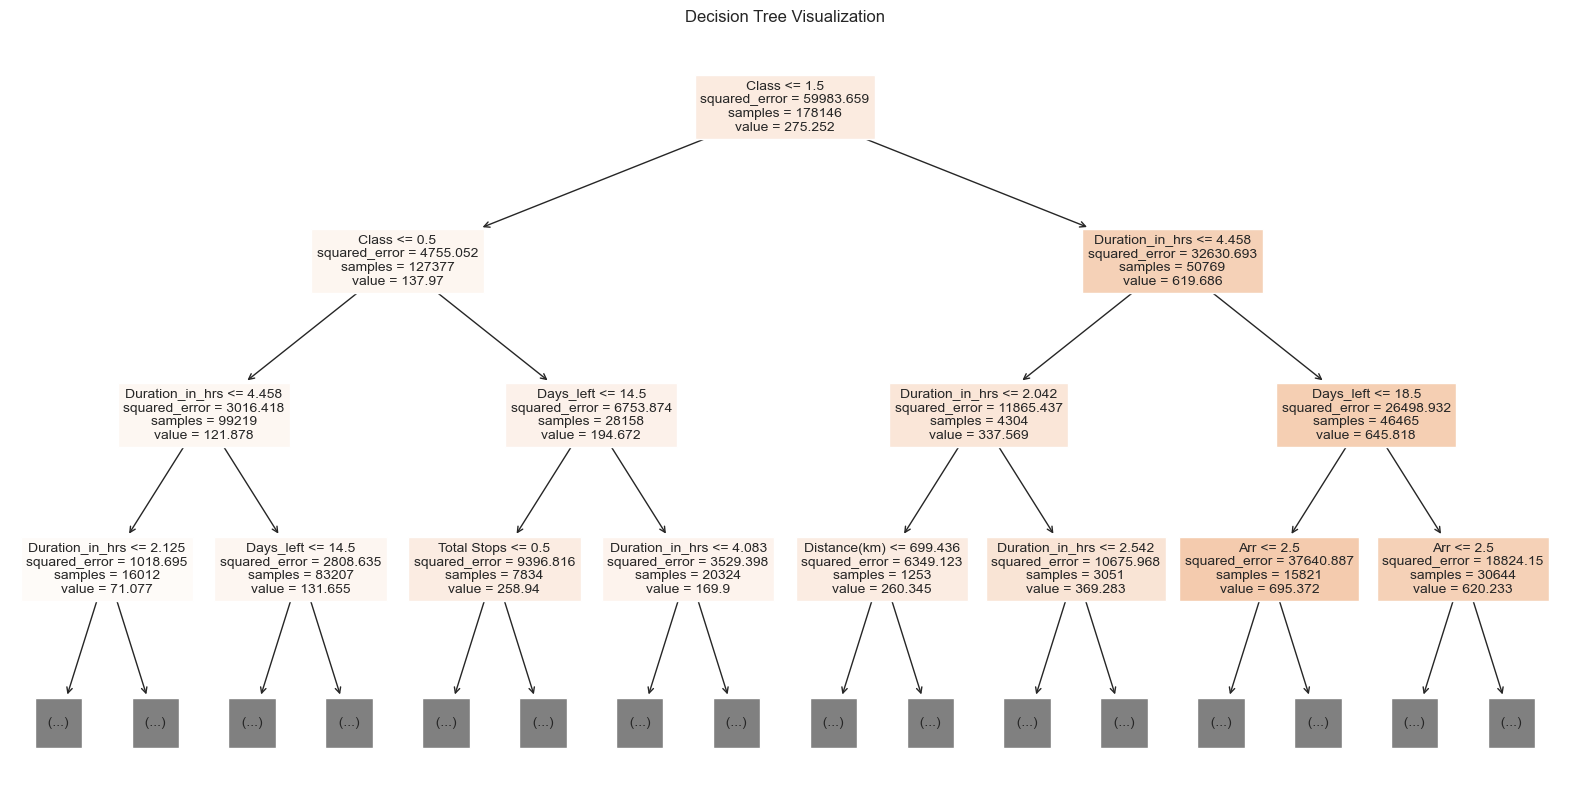

In [35]:
# Importing necessary libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_test, y_test are already defined

# Initialize the Decision Tree Regressor
decision_tree = DecisionTreeRegressor()

# Fit the model to the training data
decision_tree.fit(X_train, y_train)

# Now, the decision_tree model is fitted and can be visualized
plt.figure(figsize=(20, 10))
feature_names_list = list(X_train.columns)
plot_tree(decision_tree, filled=True, feature_names=feature_names_list, max_depth=3, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()


## Random Forest

To optimize a Random Forest model and prevent overfitting, we tune various hyperparameters using **cross-validation**. Some of the key hyperparameters to consider are:
- n_estimators: Number of trees in the forest.
- max_depth: Maximum depth of each tree.
- min_samples_split: Minimum number of samples required to split an internal node.
- min_samples_leaf: Minimum number of samples required to be at a leaf node.
- max_features: Number of features to consider when looking for the best split.

Using GridSearchCV or RandomizedSearchCV from Scikit-learn, we can systematically explore combinations of these parameters. Here's we utilize **RandomizedSearchCV** for its computational efficiency:

In [ ]:
# random_forest = RandomForestRegressor()
# random_forest.fit(X_train, y_train)
# print(X_test)
# y_pred_rf = random_forest.predict(X_test)
# mae_rf = mean_absolute_error(y_test, y_pred_rf)
# mse_rf = mean_squared_error(y_test, y_pred_rf)
# r2_rf = r2_score(y_test, y_pred_rf)
# print("Random Forest:")
# print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
# print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
# print(f"R-squared (R2) Score: {r2_rf:.2f}")


from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the parameter grid
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the Random Forest model
random_forest = RandomForestRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(random_forest, param_distributions, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Evaluate the best model on the test set
best_random_forest = random_search.best_estimator_
y_pred_rf = best_random_forest.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Optimized Random Forest:")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R-squared (R2) Score: {r2_rf:.2f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  22.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  22.6s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  22.7s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_e

**RandomizedSearchCV** will randomly sample from the defined parameter grid and perform cross-validation for each combination. This approach is usually faster than GridSearchCV, which exhaustively tries every combination.

- n_iter controls the number of different parameter settings that are sampled.
- cv determines the cross-validation splitting strategy.
- n_jobs=-1 tells the process to use all available cores for parallel processing.

This process helps find the most effective parameter settings for our RandomForestRegressor model. Once we have these settings, you can retrain your model using them and evaluate its performance on the test set.

# Model Evaluation

Random Forest model has the lowest MAE and MSE, and the highest R-squared value of 0.96, which means it performed the best out of all the models presented. It is followed by the Decision Tree model, which also has relatively low MAE and MSE, and a high R-squared value of 0.92.

In summary, the Random Forest model is the best model among those tested.

In [ ]:
y_pred = random_forest.predict(X_test)
comparison_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})
comparison_df['Difference'] = comparison_df['Actual Price'] - comparison_df['Predicted Price']
comparison_df.tail(20)

As we can see, the difference is very very small as we approach to the end of the model.

## Predictions on New Data

In [ ]:
# Use the chosen model to make predictions on new, unseen data.
# If the new data is in a CSV file, repeat the preprocessing steps before making predictions
from joblib import load
loaded_model = random_forest
file_path = 'Predict.csv'
df = pd.read_csv(file_path)

# Splitting columns and renaming them
df[["Airline", "Flight_Code", "Class"]] = df.pop("Airline-Class").str.split('\n', expand=True)
df[["Departure", "Source"]] = df.pop("Departure Time").str.split('\n', expand=True)
df[["Arrival", "Destination"]] = df.pop("Arrival Time").str.split('\n', expand=True)

# Handling date-time conversions and feature creation in one step
df["Date of Booking"] = pd.to_datetime(df["Date of Booking"], format="%d/%m/%Y")
df["Date of Journey"] = pd.to_datetime(df["Date of Journey"], format="%d/%m/%Y")
df["Days_left"] = (df["Date of Journey"] - df["Date of Booking"]).dt.days

# e.g. 2023-03-15 becomes "Wednesday"
df["Journey_day"] = df["Date of Journey"].dt.day_name()

# Simplifying the time to part of the day transformation
time_to_part = lambda time: (
    "Early Morning" if 0 <= time < 5 else
    "Morning" if 5 <= time < 12 else
    "Afternoon" if 12 <= time < 16 else
    "Evening" if 16 <= time < 19 else
    "Night" if 19 <= time < 22 else
    "Late Night"
)

df["Dep"] = pd.to_datetime(df.pop('Departure'), format='%H:%M').dt.hour.apply(time_to_part)
df["Arr"] = pd.to_datetime(df.pop('Arrival'), format='%H:%M').dt.hour.apply(time_to_part)

# Creating 'Route' column and processing 'Price'
df["Route"] = df["Source"] + "-->" + df["Destination"]


# Handling the duration in hours
df["Duration_in_hrs"] = df["Duration"].str.replace(r'(\d+)h (\d+)m', lambda x: str(int(x.group(1)) + int(x.group(2))/60), regex=True).astype(float)

# Handling Total Stops
df["Total Stops"].value_counts()
df['Total Stops'] = df['Total Stops'].apply(lambda x: 'non-stop' if 'non-stop' in x
                                                         else '1-stop' if '1-stop' in x
                                                         else '2+-stop' if '2+-stop' in x
                                                         else x)

# Dropping unnecessary columns
df.drop(["Date of Booking", "Duration"], axis=1, inplace=True)

# Visualize the relationship with a point plot
df['Day_Type'] = df['Journey_day'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)


import math
cities = {
    "Delhi": (28.7041, 77.1025),
    "Mumbai": (19.0760, 72.8777),
    "Bangalore": (12.9716, 77.5946),
    "Hyderabad": (17.3850, 78.4867),
    "Kolkata": (22.5726, 88.3639),
    "Chennai": (13.0827, 80.2707),
    "Ahmedabad": (23.0225, 72.5714),
    "SJC": (37.3639, -121.9290),
    "ATL": (33.6407, -84.4277),  # Hartsfield-Jackson Atlanta International Airport
    "LAX": (33.9416, -118.4085),  # Los Angeles International Airport
    "ORD": (41.9742, -87.9073),   # Chicago O'Hare International Airport
    "DFW": (32.8998, -97.0403),   # Dallas/Fort Worth International Airport
    "DEN": (39.8561, -104.6737),  # Denver International Airport
    "JFK": (40.6413, -73.7781),   # John F. Kennedy International Airport
    "SFO": (37.7749, -122.4194),  # San Francisco International Airport
    "SEA": (47.4502, -122.3088),  # Seattle-Tacoma International Airport
    "MIA": (25.7959, -80.2870),   # Miami International Airport
    "MCO": (28.4312, -81.3080),   # Orlando International Airport
    "MSP": (44.8848, -93.2223),   # Minneapolis-Saint Paul International Airport
    "EWR": (40.6895, -74.1745),   # Newark Liberty International Airport
    "LAS": (36.0856, -115.1507),  # McCarran International Airport
    "CLT": (35.2140, -80.9431),   # Charlotte Douglas International Airport
    "PHX": (33.4373, -112.0078)   # Phoenix Sky Harbor International Airport
}


# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

# Function to calculate distance between two cities in a DataFrame row
def calculate_distance(row):
    city1, city2 = row['Source'], row['Destination']
    lat1, lon1 = cities[city1]
    lat2, lon2 = cities[city2]
    return haversine(lat1, lon1, lat2, lon2)

# Apply the function to each row
df['Distance(km)'] = df.apply(calculate_distance, axis=1)
df_temp = df.copy()
df_temp = df_temp.drop('Flight_Code', axis=1)

df_enc = df_temp.copy()

df_enc['Total Stops'] = df_enc['Total Stops'].replace({'non-stop': 0, '1-stop': 1, '2+-stop': 2}).astype(int)
df_enc['Class'] = df_enc['Class'].replace({'ECONOMY': 0, 'PREMIUMECONOMY': 1, 'BUSINESS': 2, 'FIRST': 3}).astype(int)
df_enc['Journey_day'] = df_enc["Journey_day"].map({'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6})
df_enc['Dep'] = df_enc['Dep'].map({'Early Morning': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4, 'Late Night': 5})
df_enc['Arr'] = df_enc['Arr'].map({'Early Morning': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4, 'Late Night': 5})
# Visualize the relationship with a point plot



# Create dummy variables for Airline, Source, Destination with 0/1 encoding
#cols = ['Airline', 'Source', 'Destination']
#dummies = pd.get_dummies(df_enc[cols], drop_first=True, dtype='uint8')
#df_enc = pd.concat([df_enc, dummies], axis=1)

df_enc.drop(['Date of Journey', 'Airline', 'Source', 'Destination', 'Route'], axis=1, inplace=True)
X = df_enc.drop('Price', axis=1)  # features
y = df_enc['Price']

print(df_enc)
y_pred = loaded_model.predict(X)
comparison_df = pd.DataFrame({'Actual Price': y, 'Predicted Price': y_pred})
comparison_df['Difference'] = comparison_df['Actual Price'] - comparison_df['Predicted Price']
comparison_df.tail(20)

## Model Deployment (Optional)

In [ ]:
# Deploy the model for real-time predictions if required.
# This might involve converting the model into a format suitable for integration into production environments.